In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

 Import training and testing dataset and making a copy of the two of them 

In [110]:
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
ctest  = test.copy()
ctrain = train.copy()

In [111]:
ctrain['train']  = 1
ctest['train']  = 0
df = pd.concat([ctrain, ctest], axis=0,sort=False)

### 1.discovering dataset

In [112]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,0
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,0
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,0
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,0


 * we have 81 Columns in this dataset ,80 of them are features(id is only used in submission)

* our dataset is of lenght of 1460(small)==>
training this small dataset(in term of length) with 80 features can lead to overfitting so we need to drop as much possible columns as we can 
* our target is SalesPrice


### 2.data Preprocessing

#### 2.1 dealing with missing values 

In [113]:
thresh=0.6
# Create a boolean mask on whether each feature less than 60% missing values.
mask = df.isna().sum() / len(df) > thresh

missing_ratio=tuple(zip(df.loc[:,mask].columns,(df.isna().sum()/df.shape[0])[mask]))

print(missing_ratio)


(('Alley', 0.9321685508735869), ('PoolQC', 0.9965741692360397), ('Fence', 0.8043850633778691), ('MiscFeature', 0.9640287769784173))


In [114]:
to_drop=[]
to_drop+=list(df.loc[:,mask].columns)
print(to_drop)
df.drop(to_drop,axis=1,inplace=True)

['Alley', 'PoolQC', 'Fence', 'MiscFeature']


separate categorical and numerical features to deal with each separately

In [115]:
categ = df.select_dtypes(include=['object'])
num =df.select_dtypes(exclude=['object'])

#### preprocessing categorical features 

dropping categorical features where one categorie(option) is dominant meaning have a frequency of more than 95% comparing to the other options 

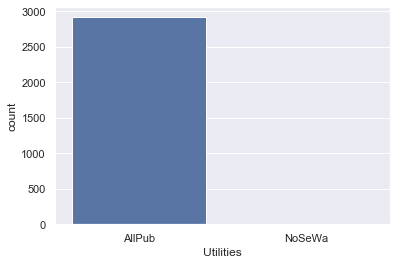

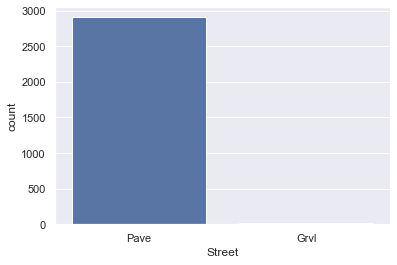

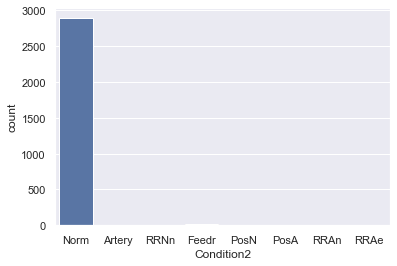

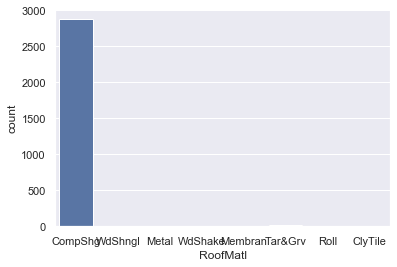

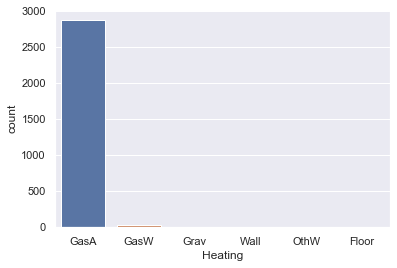

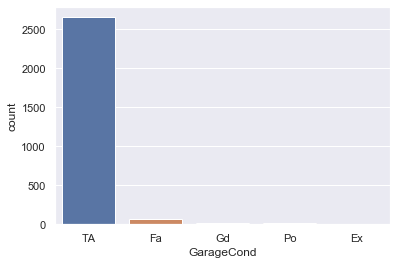

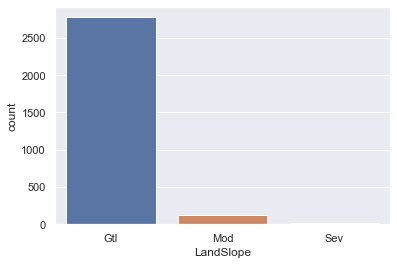

In [116]:
ratio=(categ.describe().loc["freq"]/categ.describe().loc["count"]).sort_values(ascending=False)
drop_freq=list(ratio[ratio>0.95].index)
to_drop=[*to_drop,*drop_freq]

sns.set(style="darkgrid")
for elt in drop_freq:
    ax = sns.countplot(x=elt, data=categ)
    plt.show()


In [117]:

print("list of features dropped due to one option domination is")
print(drop_freq)
categ.drop(drop_freq,axis=1,inplace=True)

list of features dropped due to one option domination is
['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'GarageCond', 'LandSlope']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##### imputing missing values in categoriacl features

In [118]:
null_counts = categ.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
MSZoning            4
LotShape            0
LandContour         0
LotConfig           0
Neighborhood        0
Condition1          0
BldgType            0
HouseStyle          0
RoofStyle           0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
PavedDrive          0
SaleType            1
SaleCondition       0
dtype: int64


In [119]:
#missing values in columns in the list below are filled with 'None' (see documentation)
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu']
categ[columns_None]=categ[columns_None].fillna('None')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [120]:
#missing values in the rest of the columns  are filled with the most frequent value(median)
categ=categ.fillna(categ.mode().iloc[0])

now we have no missing values in categorical features 

In [121]:
print(categ.isnull().sum())

MSZoning         0
LotShape         0
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
BldgType         0
HouseStyle       0
RoofStyle        0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
PavedDrive       0
SaleType         0
SaleCondition    0
dtype: int64


#### preprocessing Numerical Features

creating new features based on existing ones(this is based on data description)

In [122]:
num['Age_m']=(num["YrSold"]-num["YearBuilt"])*12+num["MoSold"]
print((num["YearBuilt"]==num["YearRemodAdd"]).sum())
to_drop=[*to_drop,*["YrSold","YearBuilt","MoSold"]]
print(to_drop)
num.drop(["YrSold","YearBuilt","MoSold"],axis=1,inplace=True)

1560
['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'GarageCond', 'LandSlope', 'YrSold', 'YearBuilt', 'MoSold']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


 we start by dropping features with low variance (less than 10**(-3)) after normalizing them  

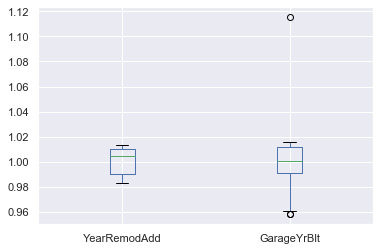

In [123]:
normalized_df = num/ num.mean()
normalized_df.loc[:,normalized_df.var()<10**(-3)].boxplot()
plt.show()
to_drop=[*to_drop,*normalized_df.loc[:,normalized_df.var()<10**(-3)].columns]

we can see that this features are 

In [124]:
num.drop(normalized_df.loc[:,normalized_df.var()<10**(-3)].columns,axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [125]:
num['LotFrontage'] = num['LotFrontage'].fillna(68)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [126]:
num.fillna(0,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


no we have a dataset clear of missing values till now we dropped

In [127]:
print(to_drop)

['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'GarageCond', 'LandSlope', 'YrSold', 'YearBuilt', 'MoSold', 'YearRemodAdd', 'GarageYrBlt']


##### check for correlation

In [128]:
corr=num.corr().abs()

mask = np.triu(np.ones_like(corr, dtype=bool))


# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool))

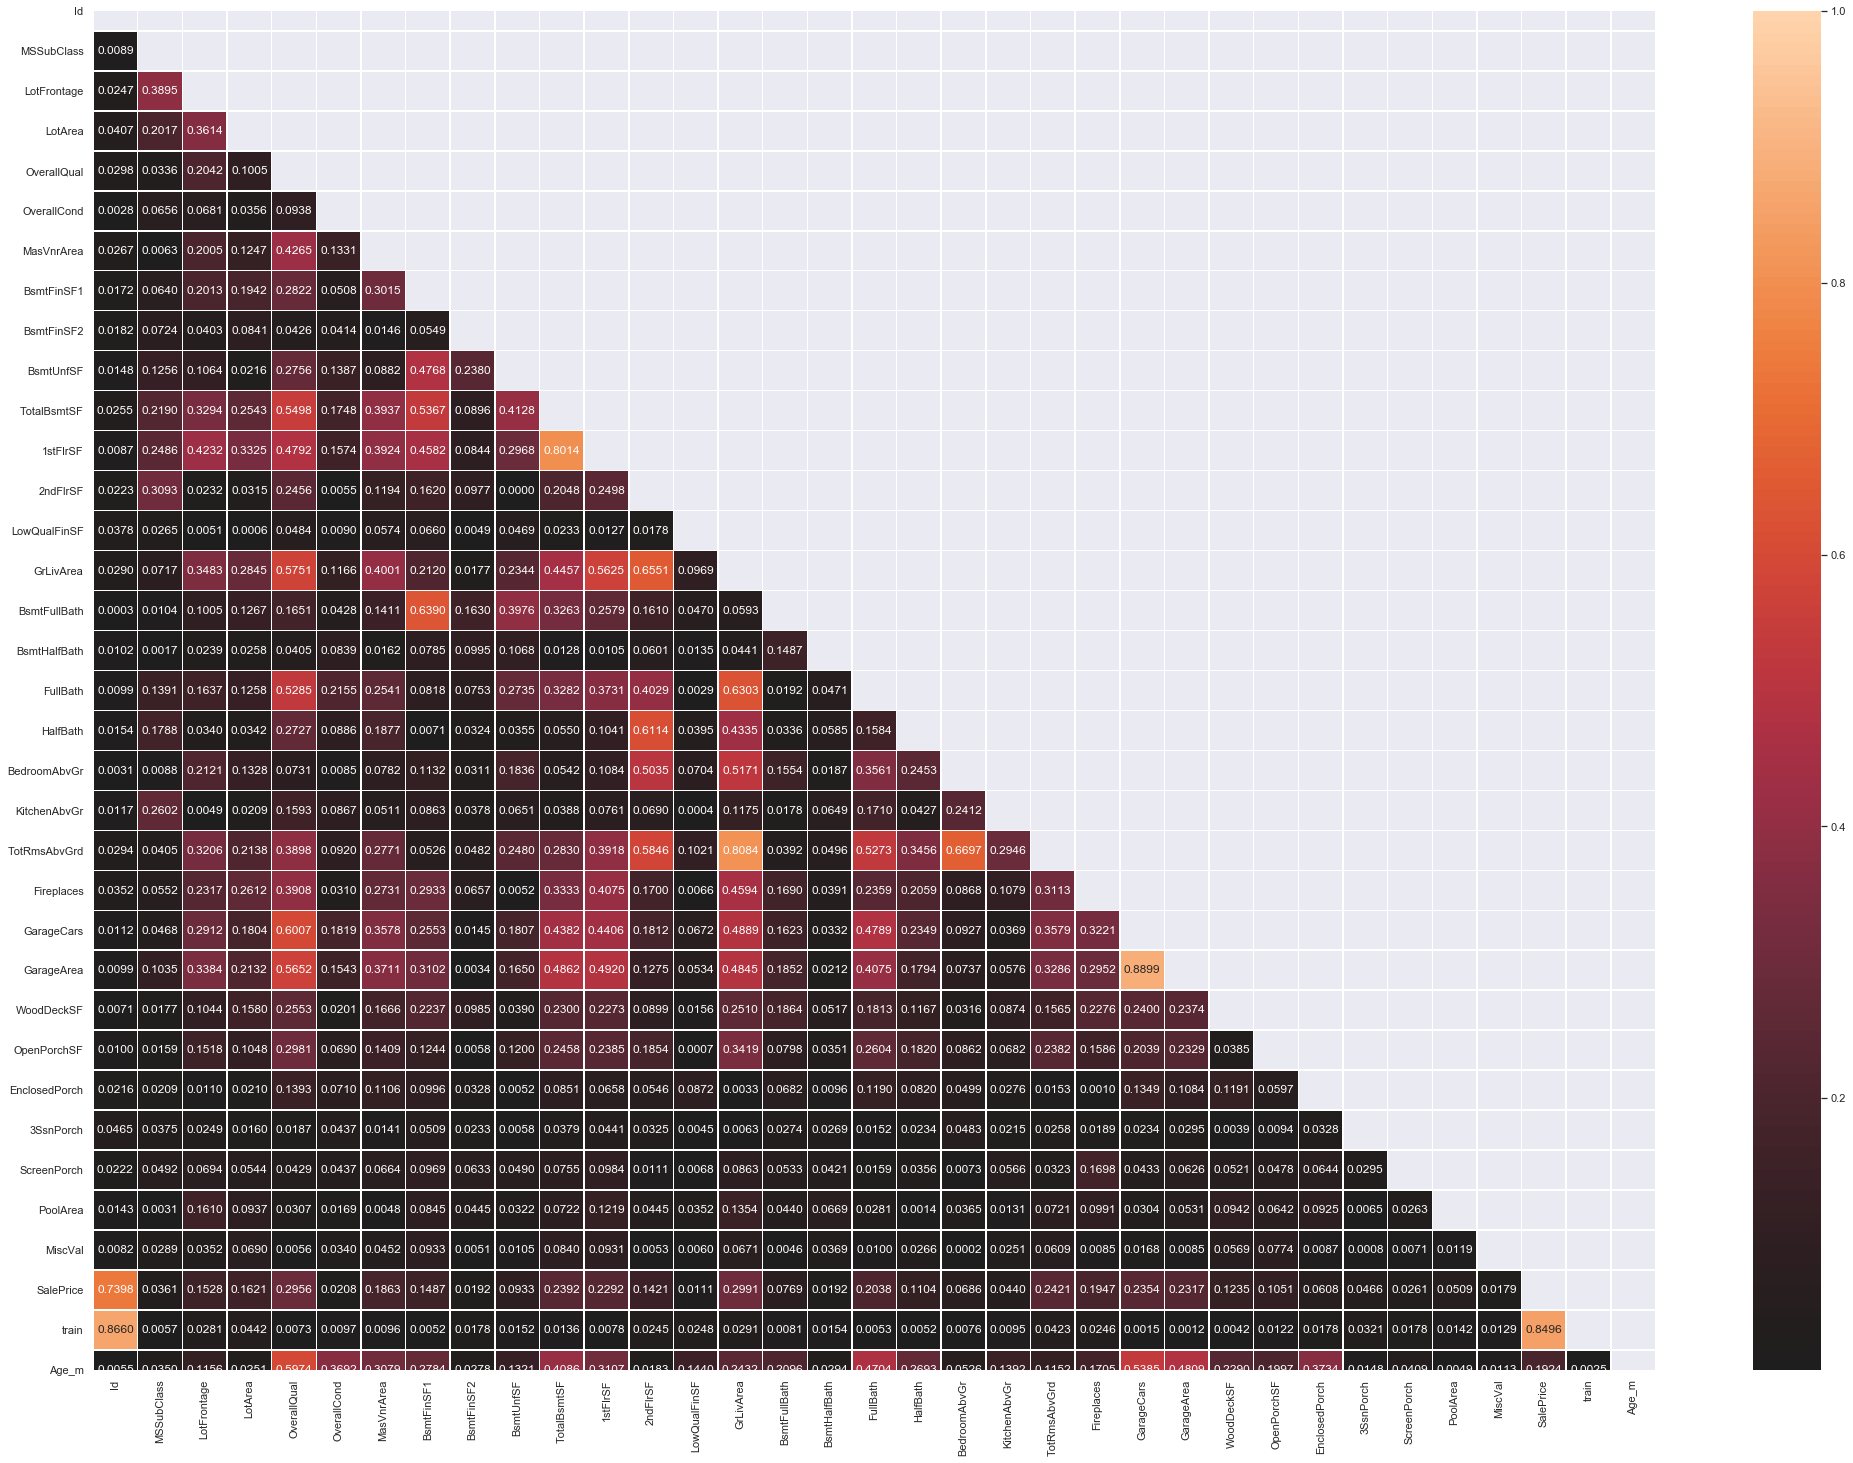

In [129]:
plt.figure(figsize=(35,25))
# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, center=0, linewidths=.5, annot=True, fmt=".4f")
plt.show()

we notice from the heatmap that there are no highly correlated features 

In [130]:
num['Age_m'].describe()

count    2919.000000
mean      443.972593
std       363.988416
min        -2.000000
25%        92.500000
50%       423.000000
75%       660.000000
max      1644.000000
Name: Age_m, dtype: float64

In [131]:
Negatif = num[num['Age_m'] < 0]
Negatif

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,train,Age_m
1089,2550,20,128.0,39290,10,5,1224.0,4010.0,0.0,1085.0,...,546,484,0,0,0,0,17000,0.0,0,-2


In [132]:
num.loc[num['Age_m']<0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [133]:
num['Age_m'].describe()

count    2919.000000
mean      443.973279
std       363.987578
min         0.000000
25%        92.500000
50%       423.000000
75%       660.000000
max      1644.000000
Name: Age_m, dtype: float64

TotalBsmtBath : Sum of : BsmtFullBath and 1/2 BsmtHalfBath

TotalBath : Sum of : FullBath and 1/2 HalfBath

TotalSA : Sum of : 1stFlrSF and 2ndFlrSF and basement area </font>

In [134]:
num['TotalBsmtBath'] = num['BsmtFullBath'] + num['BsmtFullBath']*0.5
num['TotalBath'] = num['FullBath'] + num['HalfBath']*0.5 
num['TotalSA']=num['TotalBsmtSF'] + num['1stFlrSF'] + num['2ndFlrSF']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [135]:
map_ord  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
ord_columns=['BsmtFinType2','BsmtFinType1','BsmtExposure','ExterQual','BsmtCond','ExterCond','BsmtQual','HeatingQC','KitchenQual','FireplaceQu','GarageQual','CentralAir','LotShape']
for cl in ord_columns:
    categ[cl] = categ[cl].map(map_ord)
    print(cl)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
categ['PavedDrive'] = categ['PavedDrive'].map(PavedDrive)




BsmtFinType2
BsmtFinType1
BsmtExposure
ExterQual
BsmtCond
ExterCond
BsmtQual
HeatingQC
KitchenQual
FireplaceQu
GarageQual
CentralAir
LotShape


In [136]:
categ.head()

,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,...,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,PavedDrive,SaleType,SaleCondition
0,RL,3,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,...,SBrkr,4,Typ,0,Attchd,RFn,2,2,WD,Normal
1,RL,3,Lvl,FR2,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,...,SBrkr,2,Typ,2,Attchd,RFn,2,2,WD,Normal
2,RL,2,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,...,SBrkr,4,Typ,2,Attchd,RFn,2,2,WD,Normal
3,RL,2,Lvl,Corner,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,...,SBrkr,4,Typ,4,Detchd,Unf,2,2,WD,Abnorml
4,RL,2,Lvl,FR2,NoRidge,Norm,1Fam,2Story,Gable,VinylSd,...,SBrkr,4,Typ,2,Attchd,RFn,2,2,WD,Normal


In [137]:
#Select categorical features
rest = categ.select_dtypes(include=['object'])
#Using One hot encoder
categ= pd.get_dummies(categ, columns=rest.columns) 
#categ.head()


In [138]:
print(categ.head())

   LotShape  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  \
0         3          4          2         4         2             2   
1         3          2          2         4         2             4   
2         2          4          2         4         2             2   
3         2          2          2         2         4             2   
4         2          4          2         4         2             3   

   BsmtFinType1  BsmtFinType2  HeatingQC  CentralAir  ...  SaleType_ConLw  \
0             6             1          4           1  ...               0   
1             5             1          4           1  ...               0   
2             6             1          4           1  ...               0   
3             5             1          4           1  ...               0   
4             6             1          4           1  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0             0             0            

In [139]:
df_clean = pd.concat([categ, num], axis=1,sort=False)

train_set = df_clean[df_clean['train'] == 1]
train_set.drop(['train',],axis=1,inplace=True)


test_set = df_clean[df_clean['train'] == 0]
test_set.drop(['SalePrice','train'],axis=1,inplace=True)


#### 3.Modeling

In [140]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(train_set.drop(['SalePrice'],axis=1),train_set['SalePrice'], test_size = 0.3, random_state=42)

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
# Fit the random forest model to the training data
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)

# Calculate the accuracy
acc = math.sqrt(mean_squared_error(y_test,rf.predict(X_test)))
acc_tr = math.sqrt(mean_squared_error(y_train,rf.predict(X_train)))

# Print the importances per feature
f_dict=dict(zip(train_set.columns, rf.feature_importances_.round(2)))
print(sorted(f_dict.items(), key=lambda x: x[1],reverse=True))

# Print accuracy
print("{0:.1} accuracy on test set.".format(acc))
print("{0:.1} accuracy on test set.".format(acc_tr))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[('TotalBath', 0.41), ('OverallQual', 0.35), ('2ndFlrSF', 0.03), ('SalePrice', 0.02), ('KitchenQual', 0.01), ('Id', 0.01), ('LotFrontage', 0.01), ('LotArea', 0.01), ('BsmtFinSF1', 0.01), ('BsmtUnfSF', 0.01), ('1stFlrSF', 0.01), ('GrLivArea', 0.01), ('GarageCars', 0.01), ('GarageArea', 0.01), ('WoodDeckSF', 0.01), ('OpenPorchSF', 0.01), ('TotalBsmtBath', 0.01), ('LotShape', 0.0), ('ExterQual', 0.0), ('ExterCond', 0.0), ('BsmtQual', 0.0), ('BsmtCond', 0.0), ('BsmtExposure', 0.0), ('BsmtFinType1', 0.0), ('BsmtFinType2', 0.0), ('HeatingQC', 0.0), ('CentralAir', 0.0), ('FireplaceQu', 0.0), ('GarageQual', 0.0), ('PavedDrive', 0.0), ('MSZoning_C (all)', 0.0), ('MSZoning_FV', 0.0), ('MSZoning_RH', 0.0), ('MSZoning_RL', 0.0), ('MSZoning_RM', 0.0), ('LandContour_Bnk', 0.0), ('LandContour_HLS', 0.0), ('LandContour_Low', 0.0), ('LandContour_Lvl', 0.0), ('LotConfig_Corner', 0.0), ('LotConfig_CulDSac', 0.0), ('LotConfig_FR2', 0.0), ('LotConfig_FR3', 0.0), ('LotConfig_Inside', 0.0), ('Neighborhood_Bl

In [142]:
# Create a mask for features importances above the threshold
mask = rf.feature_importances_>0.001

# Prints out the mask
print(y_train)
# Apply the mask to the feature dataset X
X_train_reduced = X_train.loc[:,mask]
X_test_reduced = X_test.loc[:,mask]

# prints out the selected column names


135     174000.0
1452    145000.0
762     215200.0
932     320000.0
435     212000.0
          ...   
1095    176432.0
1130    135000.0
1294    115000.0
860     189950.0
1126    174000.0
Name: SalePrice, Length: 1022, dtype: float64


In [143]:
# Fit the random forest model to the training data
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train_reduced,y_train)

# Calculate the accuracy
acc = math.sqrt(mean_squared_error(y_test,rf.predict(X_test_reduced)))
acc_tr = math.sqrt(mean_squared_error(y_train,rf.predict(X_train_reduced)))

# Print the importances per feature
f_dict=dict(zip(train_set.columns, rf.feature_importances_.round(2)))
print(sorted(f_dict.items(), key=lambda x: x[1],reverse=True))

# Print accuracy
print("{0:.1} accuracy on test set.".format(acc))
print("{0:.1} accuracy on test set.".format(acc_tr))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[('Neighborhood_MeadowV', 0.41), ('MSZoning_RM', 0.35), ('LotConfig_FR2', 0.03), ('MSZoning_RL', 0.02), ('Neighborhood_Gilbert', 0.02), ('BsmtExposure', 0.01), ('MSZoning_C (all)', 0.01), ('MSZoning_RH', 0.01), ('LandContour_Bnk', 0.01), ('LandContour_Low', 0.01), ('LandContour_Lvl', 0.01), ('LotConfig_Corner', 0.01), ('LotConfig_CulDSac', 0.01), ('LotConfig_FR3', 0.01), ('Neighborhood_BrkSide', 0.01), ('Neighborhood_ClearCr', 0.01), ('Neighborhood_CollgCr', 0.01), ('Neighborhood_IDOTRR', 0.01), ('LotShape', 0.0), ('ExterQual', 0.0), ('ExterCond', 0.0), ('BsmtQual', 0.0), ('BsmtCond', 0.0), ('BsmtFinType1', 0.0), ('BsmtFinType2', 0.0), ('HeatingQC', 0.0), ('CentralAir', 0.0), ('KitchenQual', 0.0), ('FireplaceQu', 0.0), ('GarageQual', 0.0), ('PavedDrive', 0.0), ('MSZoning_FV', 0.0), ('LandContour_HLS', 0.0), ('LotConfig_Inside', 0.0), ('Neighborhood_Blmngtn', 0.0), ('Neighborhood_Blueste', 0.0), ('Neighborhood_BrDale', 0.0), ('Neighborhood_Crawfor', 0.0), ('Neighborhood_Edwards', 0.0)]


In [92]:
from xgboost import XGBRegressor
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.01,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1.5, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=3)

In [93]:
#Fitting
xgb.fit(X_train_reduced, y_train)
predict1 = xgb.predict(X_test_reduced)
print('Root Mean Square Error test = ' + str(math.sqrt(mean_squared_error(y_test, predict1))))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Root Mean Square Error test = 22646.722523199205


ModuleNotFoundError: No module named 'lightgbm'

In [96]:
#Fitting
xgb.fit(X_train, y_train)
predict1 = xgb.predict(X_test)
print('Root Mean Square Error test = ' + str(math.sqrt(mean_squared_error(y_test, predict1))))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Root Mean Square Error test = 22238.615746761498


In [99]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import RandomizedSearchCV
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'n_estimators': [1000,2000,300],'reg_lambda':[0.5,0.6,0.8],'min_child_weight':[1,1.5,2]}


# Instantiate the GridSearchCV object: logreg_cv
xgb_cv = RandomizedSearchCV(xgb,param_grid, cv=5)

# Fit it to the data
xgb_cv.fit(X_train,y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(xgb_cv.best_params_)) 
print("Best score is {}".format(xgb_cv.best_score_))

<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaco

Tuned Logistic Regression Parameters: {'reg_lambda': 0.5, 'n_estimators': 2000, 'min_child_weight': 1}
Best score is 0.8320122418246282


In [144]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor


estimators =  [('xgb',xgb.XGBRegressor(n_estimators  = 200,learning_rate = 0.02, max_depth = 6)),
               ('lgbm',LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       ))]

ensemble = StackingRegressor(estimators      =  estimators,
                             final_estimator =  RandomForestRegressor())

# Fit ensemble using cross-validation
ensemble.fit(X_train, y_train).score(X_test, y_test)

# Prediction
predictions = ensemble.predict(X_test)
print('Root Mean Square Error test = ' + str(math.sqrt(mean_squared_error(y_test, predictions))))

ImportError: cannot import name 'StackingRegressor' from 'sklearn.ensemble' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\__init__.py)

In [102]:
print(xgb_cv)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.6, gamma=0.01,
                                          importance_type='gain',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=6, min_child_weight=1.5,
                                          missing=None, n_estimators=2000,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarede...
                                          random_state=0, reg_alpha=0.6,
                                          reg_lambda=0.6, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=0.8,


In [97]:
xgb.fit(train_set.drop(["SalePrice"],axis=1),train_set["SalePrice"])
predict_y = xgb.predict(test_set)

submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predict_y
    })
submission.to_csv('submission.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


<IPython.core.display.Javascript object>